In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import power

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Low Power vs Effect Size Exaggeration (M-Type Error)

In **randomized controlled trials** (**RCT**s), and in statistical research generally, the notion of **power** is used to quantify a study's ability to **detect** a **true effect** or relationship between variables, **if one actually exists**.

But when a study has a low power, and the effect is detected as statistically significant, this effect will likely be exaggerated.

In other words, on average, the estimated effect size in low-power studies will be, when averaged over a large amount of studies, larger than the real effect, a phenomenon known as the **M-Type** ("M" stands for **magnitude**) error.

This notebook presents a simulation of a set of studies, demostrating the relationship between power and effect estimate errors.


A part of [CausalPython](https://causalpython.io) series on causality.

<a href="https://causalpython.io"><img src="img/CausalPython.io__flat.png" width=150 align="left"></a>
<br>

## Define & test helpers

In [2]:
def cohen_d_theoretical(m1, m2, sd1, sd2):
    pooled_sd = np.sqrt((sd1**2 + sd2**2) / 2)
    return np.abs((m1 - m2) / pooled_sd)

In [3]:
# Test 1 -> expected 0.16(6)
print(cohen_d_theoretical(100, 102.5, 15, 15))

# Test 2 -> expected 1.0
print(cohen_d_theoretical(100, 115, 15, 15))

0.16666666666666666
1.0


In [4]:
# def cohen_d_empirical(x1, x2):
#     n1 = len(x1)
#     n2 = len(x2)
#     pooled_sd = np.sqrt((np.var(x1, ddof=1) + np.var(x2, ddof=1)) / 2)
#     return np.abs(np.mean(x1) - np.mean(x2)) / pooled_sd

## Simulation

**Study description**
Imagine we study the impact of creatine supplementation on an IQ test performance as defined by Raven's Advanced Progressive Matrices (RAPM) scores.

Normalized IQ scores in population are distributed normally with $\mu=100$ and $SD=15$.

Let's imagine that 5g of creatine consumed 1h before taking the test, increases the achieved result by 2.5 on average, hence in the experimental group the scores will be distributed normally with $\mu=102.5$ and $SD=15$.

**Note:** this scenario is made up. It seems that creatine has no bearing on RAPM performance (see https://pmc.ncbi.nlm.nih.gov/articles/PMC10647179/), but an earlier smaller study suggested otherwise (see https://pmc.ncbi.nlm.nih.gov/articles/instance/1691485/pdf/14561278.pdf).

Was that a result of a lack of power and exggerated effects?



**Action plan**

1. Find sample sizes required for a given level of power
2. Generate $k$ datasets for each scenario
3. Analyze the results and capture the extent of M-type bias



### Get sample sizes

In [6]:
# Get expected Cohen's d (for sample size calculations)
cohen_d = cohen_d_theoretical(100, 102.5, 15, 15)

# Define power levels
powers = [.2, .33, .5, .66, .8, .9, .99]

# Capture respective sample sizes
sample_sizes = []

power_analysis = power.TTestIndPower()

for p in powers:
    sample_sizes.append(
        np.round(
            power_analysis.solve_power(
                effect_size=cohen_d,
                power=p,
                alpha=0.05
            )
        ).astype(int)
    )

In [7]:
sample_sizes

[np.int64(90),
 np.int64(167),
 np.int64(278),
 np.int64(406),
 np.int64(566),
 np.int64(757),
 np.int64(1324)]

### Run the simulations

In [8]:
N_RUNS = 1000

results = []

for p, s in zip(powers, sample_sizes):
    for run in tqdm(range(N_RUNS)):
        
        # Simulate the data
        s1 = stats.norm(100, 15).rvs(s)
        s2 = stats.norm(102.5, 15).rvs(s)
        
        # Difference in means
        diff = s2.mean() - s1.mean()
        
        # Test for the differences
        t_result = stats.ttest_ind(s1, s2)
        
        # Store results
        results.append(
            {
                'power': p,
                'mean_diff': diff,
                'p_val': t_result.pvalue
            }
        )

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 262.33it/s]


In [9]:
df_results = pd.DataFrame(results)

## Analyze the results

In [10]:
df_results.groupby('power').mean()

,mean_diff,p_val
power,,
0.20,2.530805,0.340500
0.33,2.431269,0.257941
0.50,2.510451,0.147825
0.66,2.513999,0.085449
0.80,2.519252,0.044364
0.90,2.510569,0.017884
0.99,2.500352,0.002833


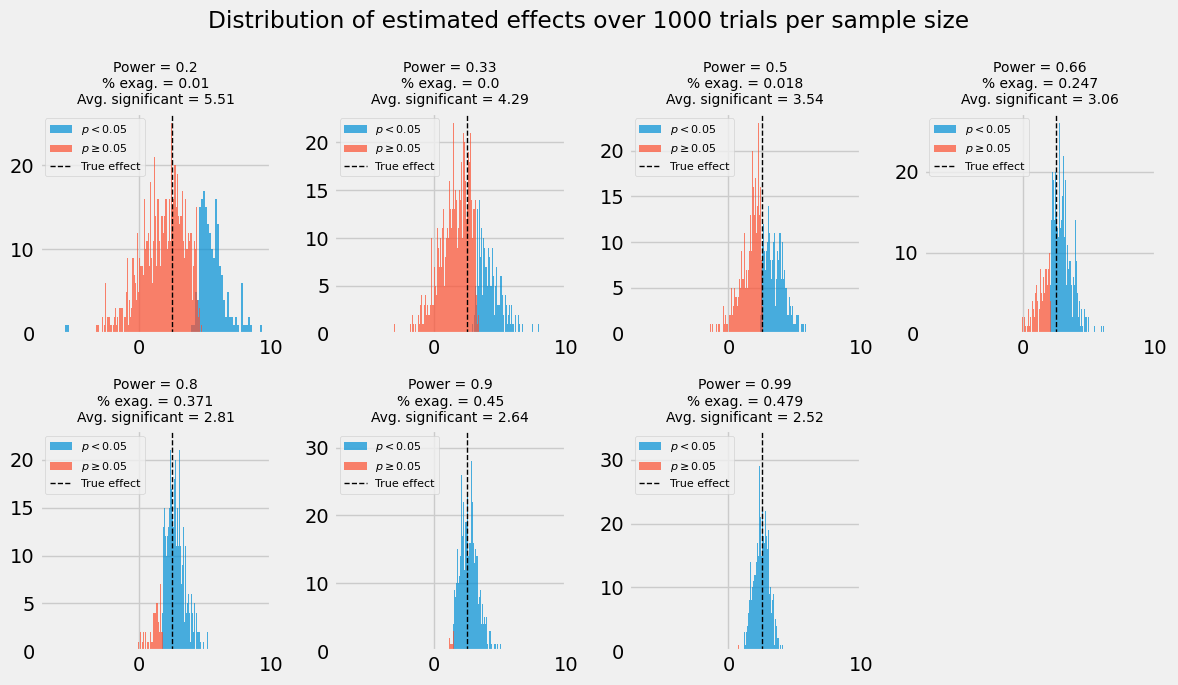

In [20]:
plt.figure(figsize=(12, 7))

for i, p in zip(range(1, df_results.shape[0] + 1), powers):
    
    # Get significant results per power level
    results_local_significant = df_results.query(f'power=={p} & p_val<0.05')
    results_local_nonsignificant = df_results.query(f'power=={p} & p_val>=0.05')
    
    percent_exag = (results_local_significant['mean_diff'] < 102.5 - 100).sum() / results_local_significant.shape[0]
    
    plt.subplot(int(f'24{i}'))
    plt.hist(
        results_local_significant['mean_diff'],
        bins=100,
        alpha=.7,
        label='$p<0.05$'
    )
    plt.hist(
        results_local_nonsignificant['mean_diff'],
        bins=100,
        alpha=.7,
        label='$p \\geq 0.05$'
    )
    plt.axvline(102.5 - 100, ls='--', lw=1, color='black', label='True effect')
    
    plt.xlim(-7.5, 10)
    
    plt.title(f'Power = {p}\n% exag. = {percent_exag.round(3)}\nAvg. significant = {results_local_significant['mean_diff'].mean().round(2)}', fontsize=10)
    plt.legend(fontsize=8)
    
plt.suptitle(f'Distribution of estimated effects over {N_RUNS} trials per sample size')
plt.tight_layout()
plt.show()